In [1]:
import os
import pandas as pd
import pyvista as pv
from core.project import Project
from striplog import Component
from utils.config import DEFAULT_LITHO_LEXICON
from definitions import ROOT_DIR

## Create a new project from a empty or existing database

In [2]:
update_db = False
db_name = './new_db.db'
db_bkp = db_name.replace('.db', '')+'_bkp.db'
if os.path.exists(db_name) and not update_db:
    if os.path.exists(db_bkp):
        os.remove(db_bkp)
    os.rename(db_name, db_bkp)

In [3]:
p = Project.load(db_name)

In [4]:
data = ROOT_DIR + '/CF_data/Memoris.xlsx'

In [5]:
bh_df = pd.read_excel(data, sheet_name='boreholes')
bh_df['ID'] = bh_df['ID'].astype('str')
bh_df.head()

,ID,X,Y,Z,Date,Length,Method,Diameter,Description,Type
0,201,152890.245758,122596.474260,101.926886,2019-10-07,2.4,Dual tube,75,Bloqué à 2.4 m sur caillasse (béton?),piezometer
1,205,152887.693175,122594.619977,101.804167,2019-10-07,4.8,Dual tube,75,NaN,piezometer
2,208,152885.295648,122592.985739,101.847697,2019-10-07,4.8,Dual tube,75,NaN,piezometer
3,207,152892.924997,122592.662277,101.889132,2019-10-07,4.8,Dual tube,75,NaN,piezometer
4,212,152882.850194,122591.453476,101.929759,2019-10-07,4.8,Dual tube,75,NaN,piezometer


In [6]:
for idx, row in bh_df.iterrows():
    bh_dict = {'id':row['ID'], 'borehole_type': row['Type'], 'length': row['Length'], 'diameter':row['Diameter']/1000.}
    if not pd.isnull(row['Date'].date()):
        bh_dict.update({'date': row['Date'].date()})
    bh_dict.update({'top':{'middle': row['Z'], 'x': row['X'], 'y': row['Y']}, 'base':{'middle': row['Z']-row['Length'], 'x': row['X'], 'y': row['Y']}})
    p.insert_borehole(bh_dict)

In [7]:
intv_df = pd.read_excel(data, sheet_name='intervals')
intv_df['ID'] = intv_df['ID'].astype('str')
intv_df.head()

,ID,De,A,Keyword,Description
0,201,0.0,0.6,Vide/Lacune,Vide
1,201,0.6,1.2,Remblais déchets de construction,Remblais avec briques de construction couleur ...
2,201,1.2,2.4,Remblais déchets de construction,Briquaille de déchets de construction et galet...
3,205,0.0,0.2,Boue,Couche de boue en surface liée à l'interventio...
4,205,0.2,0.4,Limon,Limon brun


In [8]:
intv_df = intv_df.merge(bh_df, how='left', left_on='ID', right_on='ID')[['ID', 'De', 'A', 'Keyword', 'Description_x', 'X', 'Y', 'Z']]
intv_df.head()

,ID,De,A,Keyword,Description_x,X,Y,Z
0,201,0.0,0.6,Vide/Lacune,Vide,152890.245758,122596.474260,101.926886
1,201,0.6,1.2,Remblais déchets de construction,Remblais avec briques de construction couleur ...,152890.245758,122596.474260,101.926886
2,201,1.2,2.4,Remblais déchets de construction,Briquaille de déchets de construction et galet...,152890.245758,122596.474260,101.926886
3,205,0.0,0.2,Boue,Couche de boue en surface liée à l'interventio...,152887.693175,122594.619977,101.804167
4,205,0.2,0.4,Limon,Limon brun,152887.693175,122594.619977,101.804167


In [9]:
intv_df['top'] = intv_df['Z'] - intv_df['De']
intv_df['base'] = intv_df['Z'] - intv_df['A']
intv_df.rename({'Description_x': 'Description'}, axis=1, inplace=True)
intv_df.head()

,ID,De,A,Keyword,Description,X,Y,Z,top,base
0,201,0.0,0.6,Vide/Lacune,Vide,152890.245758,122596.474260,101.926886,101.926886,101.326886
1,201,0.6,1.2,Remblais déchets de construction,Remblais avec briques de construction couleur ...,152890.245758,122596.474260,101.926886,101.326886,100.726886
2,201,1.2,2.4,Remblais déchets de construction,Briquaille de déchets de construction et galet...,152890.245758,122596.474260,101.926886,100.726886,99.526886
3,205,0.0,0.2,Boue,Couche de boue en surface liée à l'interventio...,152887.693175,122594.619977,101.804167,101.804167,101.604167
4,205,0.2,0.4,Limon,Limon brun,152887.693175,122594.619977,101.804167,101.604167,101.404167


In [10]:
bh = ''
intv_nr = 0
for idx, row in intv_df.iterrows():
    if row.ID!=bh:
        bh=row.ID
        intv_nr=0
    else:
        intv_nr+=1
    components = Component.from_text(row['Keyword'].replace('emblais', 'emblai'), DEFAULT_LITHO_LEXICON, first_only=True).__dict__
    if len(components)==0:
        components=[]
        print(f'Could not derive a component from {row["Keyword"]} in interval {intv_nr} of borehole {row.ID}.')
    else:
        components= [str(components)]
    intv_dict={'description': row['Description'],
           'top':{'middle': row.top, 'x': row.X, 'y': row.Y},
           'base':{'middle': row.base, 'x': row.X, 'y': row.Y},
           'interval_number': intv_nr,
           'components': components,
           'extra_data': 'None'
          }
    p.insert_interval_in_borehole(row.ID, intv_dict)

Could not derive a component from Terre arable in interval 0 of borehole F1aM.
Could not derive a component from Pointe perdue  in interval 0 of borehole F1bM.
Could not derive a component from Terre arable in interval 0 of borehole F12M.


In [11]:
p.repr_attribute='lithology'

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


In [12]:
p.refresh(update_3d=True)

### Visualization

In [13]:
bh_name = '201'

In [14]:
p.boreholes_3d[bh_name].intervals

[Interval({'top': Position({'middle': 101.926886, 'x': 152890.245758, 'y': 122596.47426, 'units': 'm'}), 'base': Position({'middle': 101.326886, 'x': 152890.245758, 'y': 122596.47426, 'units': 'm'}), 'description': 'Vide ', 'data': {}, 'components': [Component({'lithology': 'vide'})]}),
 Interval({'top': Position({'middle': 101.326886, 'x': 152890.245758, 'y': 122596.47426, 'units': 'm'}), 'base': Position({'middle': 100.726886, 'x': 152890.245758, 'y': 122596.47426, 'units': 'm'}), 'description': 'Remblais avec briques de construction couleur orange, gris, verdâtre  ', 'data': {}, 'components': [Component({'lithology': 'remblai'})]}),
 Interval({'top': Position({'middle': 100.726886, 'x': 152890.245758, 'y': 122596.47426, 'units': 'm'}), 'base': Position({'middle': 99.52688599999999, 'x': 152890.245758, 'y': 122596.47426, 'units': 'm'}), 'description': "Briquaille de déchets de construction et galets roulés - présence d'eau - légère odeur de naphtalène - Bloqué à 2,4 m sur caillasse (

In [15]:
sel_intervals = p.boreholes_orm[bh_name].intervals
print(len(sel_intervals.keys()), 'intervals')
sel_intervals[list(sel_intervals.keys())[1]]

4 intervals


<core.orm.IntervalOrm>(Id=80, top=<core.orm.PositionOrm object at 0x7f2bd819c520>, base=<core.orm.PositionOrm object at 0x7f2bd819ce80>, Description=Vide , Components=[<core.orm.ComponentOrm>(Id=4, Description={'lithology': 'vide'})])

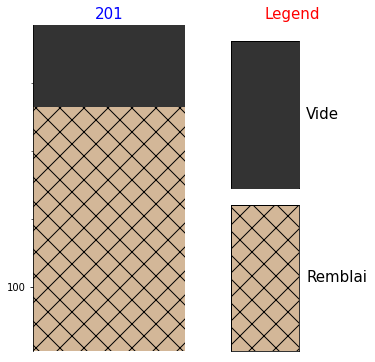

In [16]:
p.plot_log(bh_name, ticks=(.5, 2))

### add ground surface

In [17]:
ground_surface = pv.read('ground_surface.vtk')
#container = pv.cube(center=(0.0, 0.0, 0.0), x_length=5.92, y_length=2.35, z_length=2.35)

In [18]:
p.repr_attribute= 'lithology' # 'borehole_type'

In [19]:
p.vtk.plot(jupyter_backend='panel')

In [20]:
pl = pv.Plotter(window_size=(800,600), notebook=False)
pl.add_mesh(p.vtk, cmap=p.cmap, scalar_bar_args=p.scalar_bar_args, show_scalar_bar=True, annotations=p.annotations)
pl.add_mesh(ground_surface, color='green', opacity=0.5 )
pl.add_axes()
pl.show()

In [21]:
p.boreholes_3d[bh_name]._vtk

PolyData (0x7f2bd7ec7f40)
  N Cells:	156
  N Points:	600
  X Bounds:	1.529e+05, 1.529e+05
  Y Bounds:	1.226e+05, 1.226e+05
  Z Bounds:	9.953e+01, 1.019e+02
  N Arrays:	4

In [22]:
p.repr_attribute

'lithology'

In [23]:
p.boreholes_3d[bh_name].legend_dict

{'borehole_type': {'legend': Legend(Decor({'_colour': '#888888', 'width': None, 'component': Component({'borehole_type': 'piezometer'}), 'hatch': None})
  Decor({'_colour': '#aa5555', 'width': None, 'component': Component({'borehole_type': 'heating tube'}), 'hatch': None})
  Decor({'_colour': '#5555aa', 'width': None, 'component': Component({'borehole_type': 'piezair'}), 'hatch': None})
  Decor({'_colour': '#999999', 'width': None, 'component': Component({'borehole_type': 'borehole'}), 'hatch': None})
  Decor({'_colour': '#999999', 'width': None, 'component': Component({'borehole_type': 'forage'}), 'hatch': None}))},
 'lithology': {'legend': Legend(Decor({'_colour': '#333333', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'vide'})})
  Decor({'_colour': '#d3b798', 'width': 3, 'hatch': 'x', 'component': Component({'lithology': 'remblai'})})
  Decor({'_colour': '#b54500', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'boue'})})
  Decor({'_colour': '#798

In [24]:
p.plot3d(window_size=(800, 600), str_annotations=True, verbose=True)

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


Borehole "201" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "205" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "208" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "207" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "212" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "214" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "217" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "221" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "223" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "224 bloqué" | attribute values -> ['vide', 'remblai', 'boue', 'limon', 'sable', 'béton']
Borehole "224" | attribute values -> ['vide', 'remblai', 'boue', 'limon',

# Tests

In [25]:
p.legend_dict['borehole_type']['legend']

Legend(Decor({'_colour': '#888888', 'width': None, 'component': Component({'borehole_type': 'piezometer'}), 'hatch': None})
Decor({'_colour': '#aa5555', 'width': None, 'component': Component({'borehole_type': 'heating tube'}), 'hatch': None})
Decor({'_colour': '#5555aa', 'width': None, 'component': Component({'borehole_type': 'piezair'}), 'hatch': None})
Decor({'_colour': '#999999', 'width': None, 'component': Component({'borehole_type': 'borehole'}), 'hatch': None})
Decor({'_colour': '#999999', 'width': None, 'component': Component({'borehole_type': 'forage'}), 'hatch': None}))

In [26]:
pl = pv.Plotter(window_size=(800,600))

In [27]:
p.boreholes_3d[0].plot3d(plotter=pl, repr_attribute='borehole_type', repr_legend_dict=p.legend_dict, 
                         repr_cmap=p.legend_dict['borehole_type']['cmap'],
                         repr_uniq_val=p.legend_dict['borehole_type']['values'])

KeyError: 0

In [28]:
p.legend_dict['borehole_type']['cmap']

KeyError: 'cmap'

In [ ]:
p.boreholes_3d[0].vtk()

In [ ]:
pl.add_mesh(p.boreholes_3d[0]._vtk)

In [ ]:
pl.show(jupyter_backend='panel')

In [ ]:
from utils.orm import get_interval_list

In [ ]:
get_interval_list(p.boreholes_orm['201'], 'borehole_type')[0][0].top.z

In [ ]:
p.boreholes_orm['201'].id

In [ ]:
p.boreholes_orm['201'].intervals.fromkeys